In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from peak_warming_calculator import *

## Define Functions

In [3]:
## SCC functions
from SCC_functions import *

In [4]:
def create_total_consumption_Pretis(years, g_ts, W_start_year=80):
    start_year = years[0]

    W = [W_start_year]
    W_previous_year = W_start_year
    for i in range(len(years) - 1):
        W_this_year = W_previous_year*np.exp(g_ts[i])
        W.append(W_this_year)
        W_previous_year = W_this_year
    
    W = np.asarray(W)
    return W

In [5]:
## calculate cost of perturbation due to carbon
## input: temperature profile, perturbed temperature profile, total consumption, and discount function

def SCC_calculator_Pretis(time_series_df_Pretis, size_of_perturbation):
    W = time_series_df_Pretis['W'].to_numpy()
    W_perturbed = time_series_df_Pretis['W perturbed'].to_numpy()
    discount_function = time_series_df_Pretis['discount function'].to_numpy()

    absolute_consumption_loss = W-W_perturbed
    discounted_consumption_loss = absolute_consumption_loss*discount_function
    area = sum(discounted_consumption_loss)
    SCC = area * 10 ** 12 / (size_of_perturbation * 10 ** 9)  # convert to dollar amount and normalise for 1 tCO2
    return SCC

In [6]:
# default settings
P_50 = 120  # 187.5 * 0.7625000000000001
P_100 = 300  # 187.5

In [7]:
start_year = 2020
end_year = 3000

In [8]:
r_minus_g = 0.015

In [9]:
W_0 = 80
g_0 = 0.02
beta = 0.001

In [10]:
consumption_growth = g_0
consumption_discount = consumption_growth + r_minus_g

In [11]:
r = 0.03
s = 0.05

In [12]:
CO2_baseline = 40

In [13]:
## MACC functions and parameters

def abatement(P, P0, P_50=P_50, r=r, s=s, P_100=P_100):  # 0.05
    if P0 >= P_50:
        print("P0 is greater than P_50")
    elif ((P_100-P0)/(P_50-P0))**(s/r) <= 2:
        print("MAC curve condition not satisfied")
    
    P_h = P0 + ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)
    Am = 1 + ((P_100 - P0) / (P_h - P0)) ** (-s / r)
    
    A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
    
    return A

## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

# Steps

## 0. Years and Initial Temperature Anomaly

In [14]:
start_year = 2020
end_year = 3000

years = create_years_array(start_year, end_year)
num_of_years = len(years)

In [15]:
## years to calculate SCC
first_perturbed_year = start_year
last_perturbed_year = 2500
year_of_perturbation = create_years_array(start_year, last_perturbed_year)

In [16]:
T_0 = 1.2

## 1. Create Unperturbed Temperature Profile

In [17]:
delta_T = 3
alpha = 0.02
T = create_geometric_T(years, T_0=T_0, alpha=alpha, delta_T=delta_T)

alternative functional form for above for the fast transition

## 2. Calculate SCC as a function of time for a range of years

In [18]:
T_TCRE_1 = 0.00045
k_s = 0.12
size_of_perturbation = 1

In [19]:
gamma = 2
D0 = 0.00236

In [20]:
# consumption_discount = 0.035
# consumption_discount = consumption_growth + 0.015

In [21]:
peak_T_Nordhaus, output_df_Nordhaus = peak_warming_calculator(consumption_discount=g_0+r_minus_g,
                                                                  consumption_growth=g_0,
                                                                  gamma=gamma, D0=D0,
                                                                  P_50=P_50, s=s, r=r, P_100=P_100,
                                                                  start_year=start_year, end_year=end_year,
                                                                  last_SCC_year=last_perturbed_year,
                                                                  T_TCRE_1=T_TCRE_1, k_s=k_s,
                                                                  T_0=T_0, delta_T=delta_T, alpha=alpha,
                                                                  size_of_perturbation=size_of_perturbation,
                                                                  CO2_baseline=CO2_baseline,
                                                                  return_all_output=True)

/Users/aaron/Documents/oxford_physics/Year_4/MPhys/drivers-of-peak-warming/peak_warming_calculator/peak_warming_calculator.py:128: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


In [22]:
P0_Nordhaus = output_df_Nordhaus['SCC'].loc[2020]

In [23]:
P0_Nordhaus

20.761229673595825

In [24]:
# consumption_discount = 0.035
# consumption_discount = consumption_growth + 0.015

SCC_list = []
SCC_list_actual = []

for j in range(len(year_of_perturbation)):
    T_perturbed = perturb_T_geometrically(years, T=T, perturbed_year=year_of_perturbation[j], T_TCRE_1=T_TCRE_1, size_of_perturbation=size_of_perturbation, k_s=k_s)
    
    g = g_0 - beta*(T[:-1]**2-T_0**2)
    g_perturbed = g_0 - beta*(T_perturbed[:-1]**2-T_0**2)
    
    consumption_discount = g[j] + r_minus_g
    discount_function = create_discount_function(years, year_of_perturbation[j], consumption_discount=consumption_discount)
    
    W = create_total_consumption_Pretis(years, g, W_start_year=W_0)
    W_perturbed = create_total_consumption_Pretis(years, g_perturbed, W_start_year=W_0)
    
    time_series_data_Pretis = {'years': years, 'W': W, 'W perturbed': W_perturbed, 'discount function': discount_function}
    time_series_df_Pretis = pd.DataFrame(data=time_series_data_Pretis).set_index('years')

    SCC = SCC_calculator_Pretis(time_series_df_Pretis, size_of_perturbation=size_of_perturbation)
    
    if j  == 0:
        P0 = SCC
        print(SCC)
    SCC_list_actual.append(SCC)
    SCC_adjusted = SCC - (P0-P0_Nordhaus)
    if SCC_adjusted < P_100:
        SCC_list.append(SCC_adjusted)
    else:
        SCC_list.append(P_100)
        break

363.6474995361756


In [25]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

In [26]:
SCC_list_actual

[363.6474995361756,
 375.1401868255511,
 386.93776701060625,
 399.0447264604003,
 411.46554547439433,
 424.20469580005187,
 437.2666383514126,
 450.6558210805429,
 464.37667698129076,
 478.433622240181,
 492.8310545718561,
 507.5733516330965,
 522.6648696548535,
 538.1099421122426,
 553.912878641541,
 570.0779640210628,
 586.6094572764275,
 603.5115909988091,
 620.788570694718,
 638.4445743658666,
 656.4837520725929]

Text(0, 0.5, 'SCC ($)')

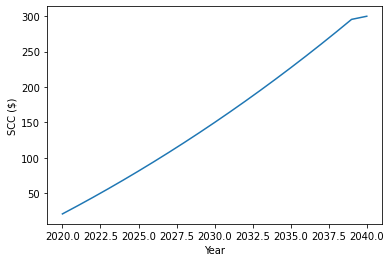

In [27]:
plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

In [28]:
SCC_array

array([ 20.76122967,  32.25391696,  44.05149715,  56.1584566 ,
        68.57927561,  81.31842594,  94.38036849, 107.76955122,
       121.49040712, 135.54735238, 149.94478471, 164.68708177,
       179.77859979, 195.22367225, 211.02660878, 227.19169416,
       243.72318741, 260.62532114, 277.90230083, 295.5583045 ,
       300.        ])

### Check 100% abatement has been achieved!

In [29]:
if SCC_array[-1] < P_100:
    print("P_100 not achieved by achieved by final perturbed year")

In [30]:
SCC_forecasted = []

for i in range(num_of_years):
    if i < len(SCC_array):
        SCC_forecasted.append(SCC_array[i])
    else:
#         SCC_forecasted.append(SCC_array[-1])
        SCC_forecasted.append(P_100)

SCC_forecasted = np.array(SCC_forecasted)

In [31]:
# SCC_forecasted

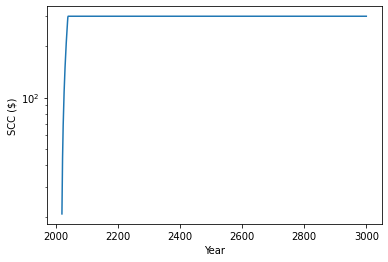

In [32]:
plt.plot(years, SCC_forecasted)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

## 3. Abatement as a function of time

In [33]:
P0 = SCC_forecasted[0]

In [34]:
forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)  # , r=consumption_discount

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_28571/3214716059.py:12: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


problems with certain values due to constraints of the model

Text(0, 0.5, 'Abatement')

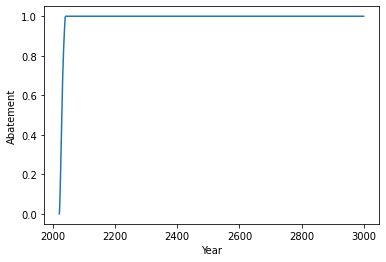

In [35]:
plt.plot(years, forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

In [36]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

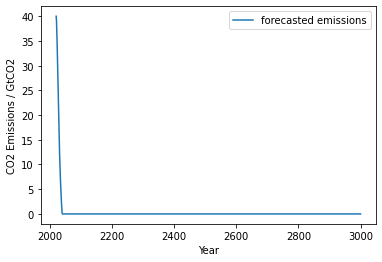

In [37]:
# plt.plot(ssp245_CO2_past, label="historical emissions")
plt.plot(years, forecasted_emissions, label="forecasted emissions")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions / GtCO2")
plt.legend()

## 5. Cumulative Emissions to Temperature Change

In [38]:
# cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

In [39]:
# temperature_change = T_TCRE_1*cumulative_emissions_array

In [40]:
# max(temperature_change)

In [41]:
T_forecast = np.ones(num_of_years)*T_0
    
for i in range(len(forecasted_emissions)):
    emission_size = forecasted_emissions[i]
    if emission_size != 0:
        T_forecast = perturb_T_geometrically(years, T=T_forecast, perturbed_year=years[i], T_TCRE_1=T_TCRE_1, k_s=k_s,size_of_perturbation=emission_size)


In [42]:
T_forecast_iteration0 = T_forecast
# T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

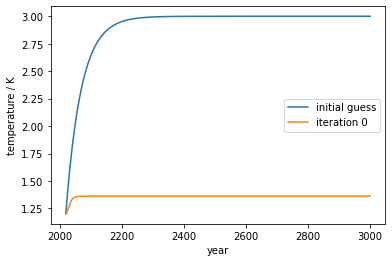

In [43]:
plt.plot(years, T, label="initial guess")
plt.plot(years, T_forecast_iteration0, label="iteration 0")
# plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("year")
plt.ylabel("temperature / K")
plt.legend()

# Iterating Further

In [44]:
# T_forecast_first_loop = T_forecast_iteration0_plateau
# T_forecast_iteration = T_forecast_iteration0_plateau

In [45]:
T_forecast_first_loop = T_forecast_iteration0
T_forecast_iteration = T_forecast_iteration0

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_28571/3214716059.py:12: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_28571/3214716059.py:12: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_28571/3214716059.py:12: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


2


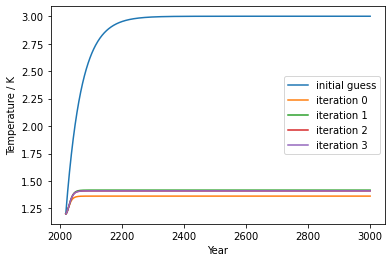

In [46]:
num_of_iterations = 99

first_perturbed_year = start_year

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(years, T, label="initial guess")
plt.plot(years, T_forecast_first_loop, label="iteration 0")

for k in range(num_of_iterations):
#     T_iteration = np.concatenate([T_gas_df['CO2_best'],T_forecast_iteration[1:]])

    SCC_list = []
    SCC_list_actual = []

    for j in range(len(year_of_perturbation)):

        T_perturbed = perturb_T_geometrically(years, T=T_forecast_iteration, perturbed_year=year_of_perturbation[j], T_TCRE_1=T_TCRE_1, size_of_perturbation=size_of_perturbation, k_s=k_s)
    
        g = g_0 - beta*(T_forecast_iteration[:-1]**2-T_0**2)
        g_perturbed = g_0 - beta*(T_perturbed[:-1]**2-T_0**2)

        consumption_discount = g[j] + r_minus_g
        discount_function = create_discount_function(years, year_of_perturbation[j], consumption_discount=consumption_discount)

        W = create_total_consumption_Pretis(years, g, W_start_year=W_0)
        W_perturbed = create_total_consumption_Pretis(years, g_perturbed, W_start_year=W_0)

        time_series_data_Pretis = {'years': years, 'W': W, 'W perturbed': W_perturbed, 'discount function': discount_function}
        time_series_df_Pretis = pd.DataFrame(data=time_series_data_Pretis).set_index('years')

        SCC = SCC_calculator_Pretis(time_series_df_Pretis, size_of_perturbation=size_of_perturbation)

        if j  == 0:
            P0 = SCC
        SCC_list_actual.append(SCC)
        SCC_adjusted = SCC - (P0-P0_Nordhaus)
        if SCC_adjusted < P_100:
            SCC_list.append(SCC_adjusted)
        else:
            SCC_list.append(P_100)
            break

    SCC_array = np.asarray(SCC_list)

    SCC_forecasted = []

    for i in range(num_of_years):
        if i < len(SCC_array):
            SCC_forecasted.append(SCC_array[i])
        else:
            SCC_forecasted.append(P_100)

    SCC_forecasted = np.array(SCC_forecasted)

    P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

#     cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

#     temperature_change = T_TCRE_1*cumulative_emissions_array
    
#     T_forecast_iteration = T_0 + temperature_change
    T_forecast = np.ones(num_of_years)*T_0
    
    for i in range(len(forecasted_emissions)):
        emission_size = forecasted_emissions[i]
        if emission_size != 0:
            T_forecast = perturb_T_geometrically(years, T=T_forecast, perturbed_year=years[i], T_TCRE_1=T_TCRE_1, k_s=k_s,size_of_perturbation=emission_size)
    
    T_forecast_iteration = T_forecast
    
    plt.plot(years, T_forecast_iteration, label="iteration "+str(k+1))
    
    if k == 0:
        peak_T = sum(forecasted_emissions) * T_TCRE_1 + T_0
    else:
        previous_peak_T = peak_T
        peak_T = sum(forecasted_emissions) * T_TCRE_1 + T_0
        if abs(peak_T - previous_peak_T) < 0.005:
            print(k)
            break
    
    if k == num_of_iterations - 1:
        print("convergence condition not achieved")
        print(f"{consumption_discount=}")
        print(f"{consumption_growth=}")
        print(f"{P_50=}")
        print(f"{s=}")
        print(f"{r=}")
        print(f"{P_100=}")

plt.xlabel("Year")
plt.ylabel("Temperature / K")
plt.legend()

***this is fairly analogous to the Newton-Raphson Method***
- the initial temperature profile is essentially just a starting guess; getting pushed toward temperature profile solution
- could stop the iterations when the difference between two consecutive lines is small

In [47]:
## peak Temperature
max(T_forecast_iteration)

1.4101471838994513

under default settings: 2.546769143595164